In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from scipy.interpolate import PchipInterpolator
from load import robust_normalize
import chart_studio.plotly as py
from plotly import __version__
%matplotlib inline
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.express as px
init_notebook_mode(connected=True)

init_notebook_mode(connected=True)
cf.go_offline()

In [8]:
def load_mes_table(user, path):
    measurement_intervals = pd.read_csv(path).set_index('user_id')
    start_time = measurement_intervals.loc[user, 'start_time']
    end_time = measurement_intervals.loc[user, 'end_time']
    return start_time, end_time

In [9]:
path = 'save_data/'
user = 497
def get_data(user, path):
    #heart_rate_
    hr_cos_raw = pd.read_csv(path + 'hr/hrt_cos_' + str(user) + '.csv')['hr_norm'].dropna()
    hr_viv_raw = pd.read_csv(path + 'hr/hrt_viv_' + str(user) + '.csv')['hr_norm'].dropna()
    #res
#     rrt_cor_raw = pd.read_csv(path + 'rr/rrt_cor_' + str(user) + '.csv')['rrt'].dropna()
#     rrt_cos_raw = pd.read_csv(path + 'rr/rrt_cos_' + str(user) + '.csv')['rrt'].dropna()
    rrt_viv_raw = pd.read_csv(path + 'rr/rrt_viv_' + str(user) + '.csv')['rrt'].dropna()
    #tmp
    tmp_cor_raw = pd.read_csv(path + 'tmp/tmp_cor_' + str(user) + '.csv')
    #ecg
    ecg_raw = pd.read_csv(path + 'ecg/hrt/ecg_viv_' + str(user) + '.csv')
    hrt_var_ecg = ecg_raw['ECG_RMSSD (ms)'].dropna()
    hrt_ecg = ecg_raw['ECG_Mean HR (beats/min)'].dropna()
    #eda
    eda_raw = pd.read_csv(path + 'eda/processed' + str(497) + '.csv')['EDA_Clean'].dropna()
    #bp
    all_ref_user_raw = pd.read_csv('/Users/binlanwu/Downloads/ALL_REFERENCE/uro_' + str(user) + '.csv')

    return hr_cos_raw, hr_viv_raw, rrt_viv_raw, tmp_cor_raw, hrt_var_ecg, hrt_ecg, eda_raw, all_ref_user_raw

In [10]:
#unpack
hr_cos, hr_viv, rrt_viv, tmp_cor, hrt_var_ecg, hrt_ecg, eda, all_ref_user = get_data(user, path)
st, et = load_mes_table(user, 'data_preprocessing/MeasurementMetadata.csv')

In [11]:
time_unit=360

### interpolating blood pressure and tmp

In [12]:
# #tmp
a = pd.read_csv(path + 'hr/hrt_viv_' + str(user) + '.csv')
# x_tmp = tmp_cor['time'].values
# y_tmp= tmp_cor['tmp'].values
x_space = a['time'].values

In [13]:
px.scatter(x= tmp_cor['time'], y = tmp_cor['tmp'])

In [14]:
# Convert datetime to Unix time
st = datetime.datetime.strptime(st, '%Y-%m-%d %H:%M:%S')
print(st)
st = datetime.datetime.timestamp(st)
# st = int(st.timestamp())

# Convert datetime to Unix time
et = datetime.datetime.strptime(et, '%Y-%m-%d %H:%M:%S')
print(et)
et = datetime.datetime.timestamp(et)
# Convert datetime to Unix time
all_ref_user = all_ref_user.loc[(all_ref_user['time'] >= st) & (all_ref_user['time'] <= et)]

2022-11-21 10:01:56
2022-11-21 10:33:00


In [15]:
def compute_diff_in_seconds(df_time, time_unit=360):
    datetime_objects = [datetime.datetime.utcfromtimestamp(ts) for ts in df_time]
    # Format the datetime objects to human-readable strings
    formatted_times = [dt.strftime('%Y-%m-%d %H:%M:%S') for dt in datetime_objects]
    # Convert the date strings to datetime objects
    start_date = datetime.datetime.strptime(formatted_times[0], '%Y-%m-%d %H:%M:%S')
    end_date = datetime.datetime.strptime(formatted_times[-1], '%Y-%m-%d %H:%M:%S')
    # Create a linearly spaced array of Unix timestamps
    unix_time_array = np.linspace(start_date.timestamp(), end_date.timestamp(), time_unit)
    # Convert Unix timestamps to datetime objects
    datetime_objects = [datetime.datetime.fromtimestamp(ts) for ts in unix_time_array]
    time_strings = [dt.strftime('%Y-%m-%d %H:%M:%S') for dt in datetime_objects]
    # Convert time strings to datetime objects
    datetime_objects = [datetime.datetime.strptime(time_str, '%Y-%m-%d %H:%M:%S') for time_str in time_strings]
    # Calculate the time difference between each datetime object and the first datetime object
    time_diffs = [(dt - datetime_objects[0]).total_seconds() for dt in datetime_objects]
    return formatted_times, time_strings, time_diffs

In [16]:
#blood pressure
if user == 497:
    x_sys = np.array([1669021801, 1669022087, 1669022383, 1669022680, 1669022975, 1669023160])
    y_sys= np.array([134, 121, 126, 120, 121, 195])
    x_dia = np.array([1669021801, 1669022087, 1669022383, 1669022680, 1669022975, 1669023160])
    y_dia= np.array([79, 89, 73, 63, 75, 95])
elif user ==473:
    x_sys = np.array([1678107632.48, 1678107774.88, 1678107880.00, 1678108187.10, 
                      1678108256.96, 1678108381.82, 1678108501.82, 1678108654.34,
                      1678108734.22, 1678108859.08, 1678109044.50, 1678109166.92, 
                      1678109299.38])
    y_sys= np.array([142, 79, 85, 93, 98, 97, 93, 76, 79, 102, 109, 162, 98])
    y_dia = np.array([66, 62, 46, 55, 59, 53, 48, 50, 50, 42, 72, 88, 60])
    x_dia= x_sys
elif user == 372:
    x_sys = np.array([1671632983.20, 1671633273.00, 1671633560.36])
    y_sys= np.array([138, 137, 133])
    y_dia = np.array([64, 66, 77])
    x_dia= x_sys
elif user == 603:
    x_sys = np.array([1673966060.00, 1673966347.36, 1673966552.12, 1673966672.10, 
                      1673966791.82, 1673966914.24, 1673967089.18, 1673967204.04,
                      1673967326.44])
    y_sys= np.array([114, 119, 119, 118, 121, 120, 120, 124, 126])
    y_dia = np.array([68, 67, 71, 68, 75, 72, 69, 68, 69])
    x_dia= x_sys
y_sys = (y_sys-y_sys[0])/y_sys[0]
y_dia = (y_dia - y_dia[0])/y_dia[0]
pchip_sys = PchipInterpolator(x_sys, y_sys, extrapolate=False)
sbp =pchip_sys(np.linspace(x_sys[0], x_sys[-1], num=time_unit))
# Identify the positions of NaN values
nan_positions = np.isnan(sbp)
# Remove NaN values using boolean indexing
sbp = sbp[~nan_positions]
# 


pchip_dia = PchipInterpolator(x_dia, y_dia, extrapolate=False)
dbp =pchip_dia(np.linspace(x_dia[0], x_dia[-1], num=time_unit))
# Identify the positions of NaN values
# Remove NaN values using boolean indexing
dbp = dbp[~nan_positions]
# dbp = (dbp-dbp[0])/dbp[0]

In [17]:
formatted_times_dia, time_strings_dia, time_diffs_dia = compute_diff_in_seconds(x_dia)
formatted_times_sys, time_strings_sys, time_diffs_sys = compute_diff_in_seconds(x_sys)

In [18]:
def compute_tick_lable(time_string):
    tick_label = [(datetime.datetime.strptime(ts,'%Y-%m-%d %H:%M:%S')-
      datetime.datetime.strptime(time_string[0], '%Y-%m-%d %H:%M:%S')).total_seconds()
      for ts in time_string]
    return tick_label
tick_label_sys = compute_tick_lable(formatted_times_sys)
tick_label_dia = compute_tick_lable(formatted_times_dia)

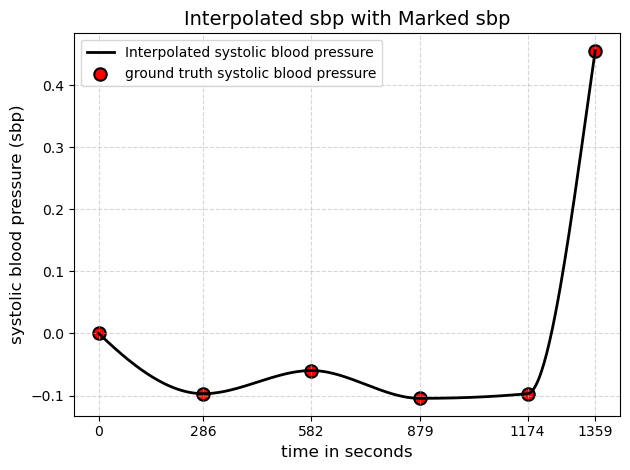

In [19]:
plt.plot(np.linspace(x_sys[0], x_sys[-1], time_unit), sbp, color = 'black', label='Interpolated systolic blood pressure', linewidth=2)
plt.scatter(x= x_sys, y = y_sys, c='red', label='ground truth systolic blood pressure', edgecolor='black', linewidth=1.5, s=80)
# Adding labels and title
plt.xlabel('time in seconds', fontsize=12)
plt.ylabel('systolic blood pressure (sbp)', fontsize=12)
plt.title('Interpolated sbp with Marked sbp', fontsize=14)

# Adding grid lines
plt.grid(True, linestyle='--', alpha=0.5)

# Adding a legend
plt.legend(fontsize=10)
cus_ticks = x_sys
cus_lable = [int(a) for a in tick_label_sys]
plt.xticks(cus_ticks, cus_lable)
# Setting the aspect ratio and adjusting subplot spacing
# plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.savefig(str(user)+'_normed_sbp.pdf')

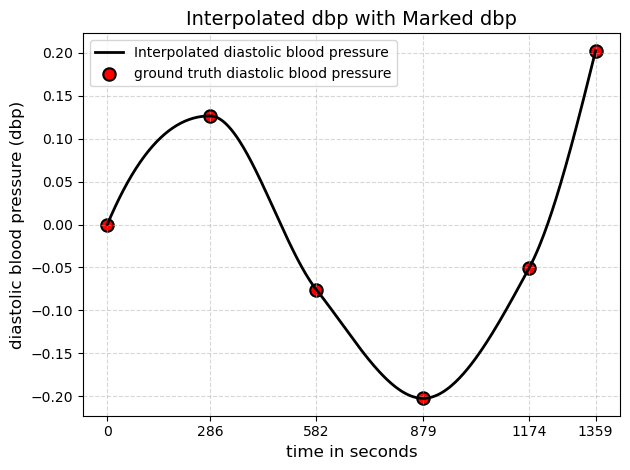

In [23]:
plt.plot(np.linspace(x_dia[0], x_dia[-1], time_unit), dbp, color = 'black', label='Interpolated diastolic blood pressure', linewidth=2)
plt.scatter(x= x_dia, y = y_dia, c='red', label='ground truth diastolic blood pressure', edgecolor='black', linewidth=1.5, s=80)
# Adding labels and title
plt.xlabel('time in seconds', fontsize=12)
plt.ylabel('diastolic blood pressure (dbp)', fontsize=12)
plt.title('Interpolated dbp with Marked dbp', fontsize=14)

# Adding grid lines
plt.grid(True, linestyle='--', alpha=0.5)

# Adding a legend
plt.legend(fontsize=10)
cus_ticks = x_dia
cus_label = [int(a) for a in tick_label_dia]
plt.xticks(cus_ticks, cus_label)
# Setting the aspect ratio and adjusting subplot spacing
# plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.savefig(str(user)+'_normed_dbp.pdf')


### Filter out outliers in respiration rate

In [24]:
px.scatter(x = np.arange(rrt_viv.shape[0]) ,y = rrt_viv) 

In [25]:
fil = (rrt_viv != -1)
rrt_viv = rrt_viv[fil]
px.scatter(x = np.arange(rrt_viv.shape[0]) ,y = rrt_viv) 

### Bladder Volumne

In [26]:
bld = all_ref_user['Vin']

### spo2

In [27]:
if user == 497:
    spo2 = pd.read_csv('/Users/binlanwu/Downloads/TUM/5.Master_Thesis_eth/graphical_modeling/data/ecg-bp-497/cosinuss_ear_spo2/K41C.9ZA0_2022-11-15_13-46-59_spo2.csv.gz', compression="gzip")
elif user == 473:
    spo2 = pd.read_csv('/Users/binlanwu/Downloads/TUM/5.Master_Thesis_eth/graphical_modeling/data/ecg-bp-473/cosinuss_ear_spo2/K41C.9ZA0_2023-03-06_13-43-50_spo2.csv.gz', compression="gzip")
elif user == 603:
    spo2 = pd.read_csv('/Users/binlanwu/Downloads/TUM/5.Master_Thesis_eth/graphical_modeling/data/ecg-bp-603/cosinuss_ear_spo2/K41C.9ZA0_2023-01-17_10-22-28_spo2.csv.gz', compression="gzip")
elif user == 372:
    spo2 = pd.read_csv('/Users/binlanwu/Downloads/TUM/5.Master_Thesis_eth/graphical_modeling/data/ecg-bp-372/cosinuss_ear_spo2/K41C.9ZA0_2022-12-05_14-00-49_spo2.csv.gz', compression="gzip")
    
spo2 = spo2.loc[(spo2['time'] >= st) & (spo2['time'] <= et)]
spo2['spo2'] = (spo2['spo2'].values-spo2['spo2'].values[0])/spo2['spo2'].values[0]

In [28]:
datetime.datetime.utcfromtimestamp(x_sys[0]).strftime('%Y-%m-%d %H:%M:%S'), datetime.datetime.utcfromtimestamp(x_sys[-1]).strftime('%Y-%m-%d %H:%M:%S')

('2022-11-21 09:10:01', '2022-11-21 09:32:40')

In [29]:
formatted_times, time_strings, time_diffs = compute_diff_in_seconds(spo2['time'].values)

In [30]:
px.scatter(x = formatted_times  ,y = spo2['spo2']) 

In [31]:
from scipy import interpolate
spo2_f = PchipInterpolator(spo2['time'], spo2['spo2'].values)
spo2_clean = spo2_f(np.linspace(spo2['time'].values[0], spo2['time'].values[-1], num=time_unit))
tick_lable_spo2 = compute_tick_lable(formatted_times)

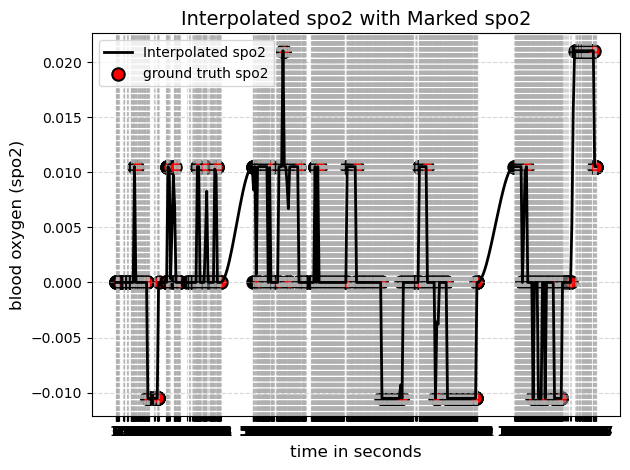

In [32]:
# plt.figure(figsize=(20, 5))
plt.plot(np.linspace(spo2['time'].values[0], spo2['time'].values[-1], num=time_unit), spo2_clean, color = 'black', label='Interpolated spo2', linewidth=2)
plt.scatter(x= spo2['time'], y = spo2['spo2'], c='red', label='ground truth spo2', edgecolor='black', linewidth=1.5, s=80)
# Adding labels and title
plt.xlabel('time in seconds', fontsize=12)
plt.ylabel('blood oxygen (spo2)', fontsize=12)
plt.title('Interpolated spo2 with Marked spo2', fontsize=14)

# Adding grid lines
plt.grid(True, linestyle='--', alpha=0.5)

# Adding a legend
plt.legend(fontsize=10)
cus_ticks = spo2['time'].values[range(0, spo2['time'].shape[0], 1)]
cus_lable = [int(tick_lable_spo2[i]) for i in range(0, spo2['time'].shape[0], 1)]
# cus_lable = [0, '', 20, 384]
plt.xticks(cus_ticks, cus_lable)
# Setting the aspect ratio and adjusting subplot spacing
# plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.savefig(str(user)+'_spo2.pdf')


#### Defining all the variables

In [33]:
from scipy import interpolate
def preprocess(hr_viv_un, hr_cos_un, rrt_viv_un, hrt_var_ecg, eda_un, spo2_un, sbp_un, dbp_un, bld_un, tmp, time_unit):
    tmp_core_f = PchipInterpolator(np.arange(tmp_cor['tmp'].values.shape[0]), robust_normalize(tmp_cor['tmp'].values))
    tmp_core_clean = tmp_core_f(np.linspace(0, tmp_cor['tmp'].values.shape[0]-1, num=time_unit))
    eda_f = PchipInterpolator(np.arange(eda_un.shape[0]), robust_normalize(eda_un))
    eda_clean = eda_f(np.linspace(0, eda_un.shape[0]-1, num=time_unit))
#     spo2_f = PchipInterpolator(np.arange(spo2_un['spo2'].values.shape[0]), robust_normalize(spo2_un['spo2'].values))
#     spo2_clean = spo2_f(np.linspace(0, spo2_un['spo2'].values.shape[0]-1, num=time_unit))
    hrt_var_ecg_f = PchipInterpolator(np.arange(hrt_var_ecg.shape[0]),robust_normalize(hrt_var_ecg))
    hrt_var_ecg_clean = hrt_var_ecg_f(np.linspace(0, hrt_var_ecg.shape[0]-1, num=time_unit))
    bld_f = PchipInterpolator(np.arange(bld.shape[0]), robust_normalize(bld))
    bld_vol = bld_f(np.linspace(0, bld.shape[0]-1, num=time_unit))
    heart_rate_f = PchipInterpolator(np.arange(hr_viv_un.shape[0]), hr_viv_un)
    heart_rate_viv = heart_rate_f(np.linspace(0, hr_viv_un.shape[0]-1, num=time_unit))
    resp_rate_f = PchipInterpolator(np.arange(rrt_viv_un.shape[0]), rrt_viv_un)
    resp_rate_viv = resp_rate_f(np.linspace(0, rrt_viv_un.shape[0]-1, num=time_unit))
#     sbp_clean_f = PchipInterpolator(np.arange(sbp.shape[0]), robust_normalize(sbp))
#     sbp_clean = sbp_clean_f(np.linspace(0, sbp.shape[0]-1, num=time_unit))
#     dbp_clean_f = PchipInterpolator(np.arange(dbp.shape[0]), robust_normalize(dbp))
#     dbp_clean = dbp_clean_f(np.linspace(0, dbp.shape[0]-1, num=time_unit))
    return tmp_core_clean, eda_clean, hrt_var_ecg_clean, spo2_clean, bld_vol, heart_rate_viv, resp_rate_viv, sbp_un, dbp_un

#### unifying the signals

In [34]:
tmp_core, eda, hrt_var_ecg, spo2, bld_vol, heart_rate_viv, resp_rate_viv, sbp, dbp = preprocess(hr_viv, hr_cos, rrt_viv, hrt_var_ecg, eda, spo2_clean, sbp, dbp, bld, tmp_cor, time_unit)

variables of interest: core temperature, eda, spo2, heart rate variability, heart rate, respiration rate and bladder volumne

In [35]:
import tigramite
from tigramite import data_processing as pp
from tigramite.toymodels import structural_causal_processes as toys
from tigramite import plotting as tp
from tigramite.lpcmci import LPCMCI
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr
from tigramite.independence_tests.cmiknn import CMIknn
from tigramite.independence_tests.regressionCI import RegressionCI

In [36]:
# hrt_var_ecg = np.array(hrt_var_ecg)
var_names = ['bld_vol', 'sbp', 'dbp', 'heart_rate_viv', 'resp_rate_viv', 'eda', 'tmp_core', 'hrt_var_ecg', 'spo2']
concatenated_array = np.column_stack((bld_vol, sbp, dbp, heart_rate_viv, resp_rate_viv, eda, tmp_core, hrt_var_ecg, spo2))
patient = pd.DataFrame(concatenated_array, columns=var_names)
patient = patient.dropna()
patient.to_csv(str(user) + str(time_unit) + '_int.csv', index=False)
dataframe = pp.DataFrame(patient.values, var_names=var_names)

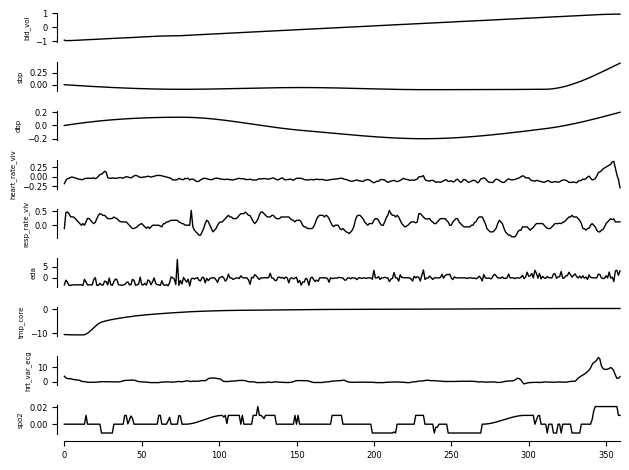

In [37]:
import matplotlib.pyplot as plt
tp.plot_timeseries(dataframe, label_fontsize=5); plt.show()

KeyError: 'graph'